# Casing Integrity Example - Mesh Validation

- compare against a dipole in a whole-space

- background resistivity average is 1.6 Ωm
- For each well we measure the radial electric fields as far out as the well is deep. We also measured magnetic fields (tangential) at a few points.
- Return Electrode: 1000m from the wellhead, perpendicular to the array of receivers (wire ran close to a straight line).
- freqs DC (1e-6), 0.1, and 1Hz
- Surface casing : outer diameter 10 3/4 in, thickness = 0.011m - set depth 1242 ft
- Production casing : outer diameter 7 in, production = 0.008m - set depth 6079 ft 
- KB 13.5ft above

In [3]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import sympy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

import casingSimulations

from pymatsolver import Pardiso

%matplotlib inline

/Users/lindseyjh/git/python_symlinks/properties/basic.py:36: FutureWarning: Deprecation warning: info_text has been renamed class_info. Consider updating class Model 
  'Consider updating class {} '.format(name), FutureWarning)
/Users/lindseyjh/git/python_symlinks/properties/basic.py:36: FutureWarning: Deprecation warning: info_text has been renamed class_info. Consider updating class Mapping 
  'Consider updating class {} '.format(name), FutureWarning)
/Users/lindseyjh/git/python_symlinks/properties/basic.py:36: FutureWarning: Deprecation warning: info_text has been renamed class_info. Consider updating class PhysicalProperty 
  'Consider updating class {} '.format(name), FutureWarning)


In [4]:
simDir = 'wellA_simple_meshValidation'

## Set up model parameters

In [5]:
# Casing diameters
surface_casing_diameter = 10.75*inch
production_casing_diameter = 7*inch

# casing depths (below surface)
kb = 13.5
surface_casing_depth = (1242-kb)*foot
production_casing_depth = (6079-kb)*foot

print(surface_casing_depth, production_casing_depth)
print(surface_casing_diameter, production_casing_diameter)

(374.44679999999994, 1848.7643999999998)
(0.27305, 0.17779999999999999)


### Simplified model

In [6]:
# Casing parameters
casing_d = 20e-2 # first pass, lets use a 20cm casing diameter
casing_t = 1e-2 # 1cm casing thickness
casing_l = 1850 # first pass, use 1850m length (close enough to 1848)

freqs = np.r_[1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5, 1.]  # 1e-6

sigma_back = 1./1.6
sigma_inside = 1.

src_a = np.r_[0., np.pi, 0.]
src_b = np.r_[1e3, np.pi, 0.]

In [47]:
# set up the casing properties - here, we want to use a whole-space. 
cp = casingSimulations.CasingParameters(
    sigma_back = sigma_back,
    sigma_layer = sigma_back,
    sigma_inside = sigma_back,
    sigma_casing = sigma_back,
    sigma_air = sigma_back, 
    mur_casing = 1,
    casing_d = casing_d,
    casing_l = casing_l,
    casing_t = casing_t, 
    freqs = freqs, 
    src_a = src_a,
    src_b = src_b
)

In [48]:
cp.save(directory=simDir)

In [49]:
cp.serialize()

{u'__class__': 'CasingParameters',
 'casing_d': 0.2,
 'casing_l': 1850.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'freqs': [0.0001, 0.001, 0.01, 0.1, 0.1, 0.2, 0.5, 1.0],
 'layer_z': [-1000.0, -900.0],
 'mur_casing': 100.0,
 'sigma_air': 1e-08,
 'sigma_back': 0.625,
 'sigma_casing': 5500000.0,
 'sigma_inside': 1.0,
 'sigma_layer': 0.625,
 'src_a': [0.0, 3.141592653589793, 0.0],
 'src_b': [1000.0, 3.141592653589793, 0.0],
 'version': u'0.0.1'}

In [50]:
cp.skin_depth()

array([ 63661.97723676,  20131.68484179,   6366.19772368,   2013.16848418,
         2013.16848418,   1423.52508683,    900.31631616,    636.61977237])

## Set up mesh

In [61]:
npadx, npadz = 17, 21
dx2 = casing_l  # go out as far as the casing is deep 
csx2 = 25.
csz = 5.
pfx2 = 1.4
pfz = 1.4

ncy = 1
nstretchy = 5
stretchfact = 1.5
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

cylMeshGen = casingSimulations.CasingMeshGenerator(
    cp=cp, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x2=dx2, 
    hy=hy, 
    csx2=csx2, 
    csz=csz,
    pfx2=pfx2, 
    pfz=pfz
)

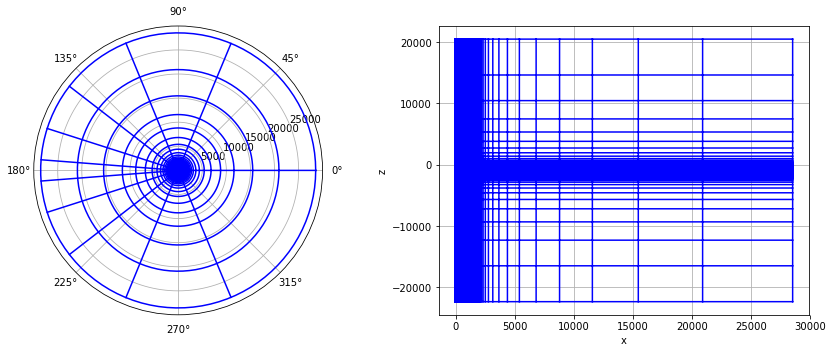

In [62]:
cylMeshGen.mesh.plotGrid()

In [63]:
print( 
    'nC: {}, max_x: {}, max_z: {}'.format(
        cylMeshGen.mesh.nC, cylMeshGen.mesh.vectorNx.max(), cylMeshGen.mesh.vectorNz.max()
    )
)

nC: 789140, max_x: 28542.4283882, max_z: 20506.2225792


In [70]:
cylMeshGen.mesh.vectorCCy

array([ 0.588141  ,  1.56837599,  2.22186599,  2.65752599,  2.94796599,
        3.14159265,  3.33521932,  3.62565932,  4.06131932,  4.71480931,
        5.69504431])

In [71]:
cylMeshGen.save(directory=simDir)

In [72]:
cylmesh = cylMeshGen.mesh

In [73]:
src = casingSimulations.sources.TopCasingSrc(cp, cylMeshGen.mesh)

(0.0, 1200)

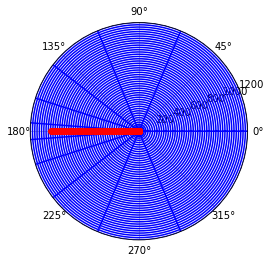

In [74]:
ax = plt.subplot(111, projection='polar')
cylmesh.plotGrid(ax=ax, slice='z')
ax.plot(cylmesh.gridFx[src.surface_wire,1], cylmesh.gridFx[src.surface_wire,0], 'ro')
ax.set_rlim([0., 1200])

(-10.0, 30.0)

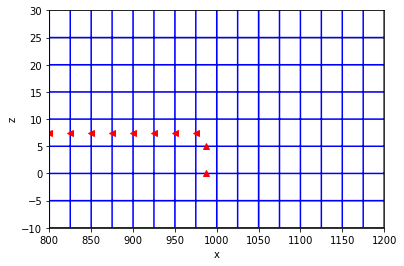

In [75]:
fig, ax = plt.subplots(1, 1)
cylmesh.plotGrid(ax=ax, slice='theta')
src.plot(ax=ax)

ax.set_xlim([800., 1200.])
ax.set_ylim([-10., 30.])

In [76]:
physprops = casingSimulations.PhysicalProperties(cylmesh, cp)

In [77]:
mesh2D = discretize.CylMesh([cylmesh.hx, 1., cylmesh.hz], x0 = cylmesh.x0)

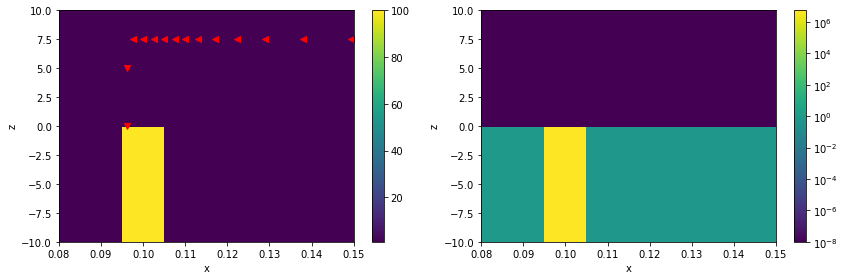

In [78]:
xlim = [0.08, 0.15]
ylim = [-10., 10.]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

murplt = physprops.mur.reshape(cylmesh.vnC, order='F')

plt.colorbar(mesh2D.plotImage(utils.mkvc(murplt[:,0,:]), ax=ax[0], mirror=True)[0], ax=ax[0])
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
src.plot(ax=ax[0])

sigmaplt = physprops.sigma.reshape(cylmesh.vnC, order='F')

plt.colorbar(
    mesh2D.plotImage(
        utils.mkvc(sigmaplt[:,0,:]), ax=ax[1], mirror=True, pcolorOpts = {'norm':LogNorm()}
    )[0], ax=ax[1],
    
)
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

plt.tight_layout()

# Load up results

In [79]:
cylMesh=casingSimulations.load_properties('/'.join([simDir, 'MeshParameters.json']))
cyl_cp = casingSimulations.load_properties('/'.join([simDir, 'CasingParameters.json']))
cyl_hfield = np.load('/'.join([simDir, 'fieldsCyl.npy']))
# simulation = casingSimulations.load_properties(
#     '/'.join([simDir, 'simulationParameters.json']), 
#     targetClass=casingSimulations.run.SimulationFDEM
# )

In [80]:
cylSimulation = casingSimulations.run.SimulationFDEM(cp=cyl_cp, meshGenerator=cylMesh, srcType='TopCasingSrc')
cylSimulation.prob.model = cylSimulation.physprops.model
cylFields = cylSimulation.prob.fieldsPair(cylMesh.mesh, cylSimulation.survey)
cylFields[:,'hSolution'] = cyl_hfield
srcList = cylSimulation.survey.srcList

In [81]:
cylmesh = cylMesh.mesh
src = cylSimulation.src

In [82]:
cp.skin_depth()

array([ 63661.97723676,  20131.68484179,   6366.19772368,   2013.16848418,
         2013.16848418,   1423.52508683,    900.31631616,    636.61977237])

In [105]:
# look at a slice along the plane of the source
srcind = 2
theta_ind = 1

jcyl = cylFields[srcList[srcind],'j']
jplt = casingSimulations.face3DthetaSlice(cylMesh.mesh, jcyl, theta_ind=theta_ind)
bcyl = cylFields[srcList[srcind], 'b']
bplt = casingSimulations.edge3DthetaSlice(cylMesh.mesh, bcyl, theta_ind=theta_ind)

print('freq: {} Hz'.format(srcList[srcind].freq))


freq: 0.01 Hz


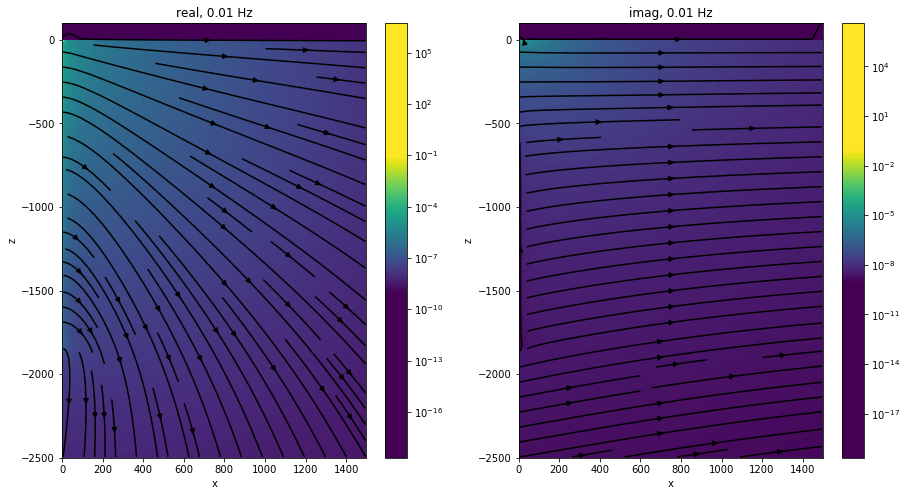

In [106]:
mesh2D = discretize.CylMesh([cylMesh.mesh.hx, 1., cylMesh.mesh.hz], x0=cylMesh.mesh.x0)

fig, ax = plt.subplots(1,2, figsize=(15, 8))
casingSimulations.plotFace2D(
    mesh2D,
    jplt, real_or_imag='real', ax=ax[0], range_x=np.r_[0., 1500.],
    range_y=np.r_[-2500., 100.], sample_grid=np.r_[10., 10.],
    logScale=True, clim=[1e-9, 1e-1]
)
ax[0].set_title('real, {} Hz'.format(srcList[srcind].freq))

casingSimulations.plotFace2D(
    mesh2D,
    jplt, real_or_imag='imag', ax=ax[1], range_x=np.r_[0., 1500.],
    range_y=np.r_[-2500., 100.], sample_grid=np.r_[10., 10.],
    logScale=True, clim=[1e-9, 1e-1]
)
ax[1].set_title('imag, {} Hz'.format(srcList[srcind].freq))

In [89]:
def ccv3DthetaSlice(mesh3D, v3D, theta_ind=0):
    """
    Grab a theta slice through a 3D field defined at cell centers

    :param discretize.CylMesh mesh3D: 3D cyl mesh
    :param numpy.ndarray v3D: vector of fields on mesh
    :param int theta_ind: index of the theta slice that you want
    """

    ccv_x = v3D[:mesh3D.nC].reshape(mesh3D.vnC, order='F')
    ccv_y = v3D[mesh3D.nC:2*mesh3D.nC].reshape(mesh3D.vnC, order='F')
    ccv_z = v3D[2*mesh3D.nC:].reshape(mesh3D.vnC, order='F')

    ccv3Dslice = np.vstack([
        utils.mkvc(ccv_x[:, theta_ind, :], 2),
        utils.mkvc(ccv_y[:, theta_ind, :], 2),
        utils.mkvc(ccv_z[:, theta_ind, :], 2)
    ])
    
    return ccv3Dslice

In [107]:
theta_ind = 1
srcind = 6

ecyl = cylFields[srcList[srcind], 'e']
eplt = ccv3DthetaSlice(cylmesh, ecyl, theta_ind=theta_ind)

In [108]:
ex = eplt[:mesh2D.nC]
ey = eplt[mesh2D.nC:2*mesh2D.nC]
ez = eplt[2*mesh2D.nC:]

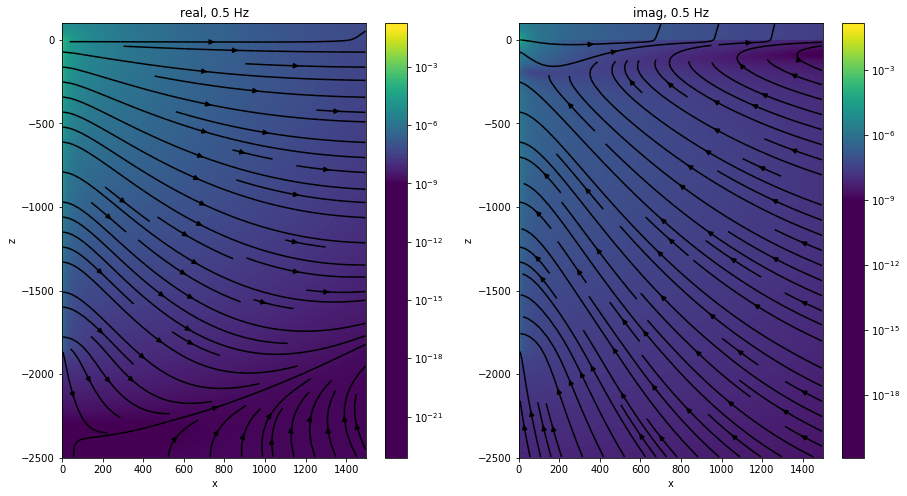

In [109]:
fig, ax = plt.subplots(1,2, figsize=(15, 8))

casingSimulations.plotFace2D(
    mesh2D,
    np.vstack([ex, ez]), real_or_imag='real', ax=ax[0], range_x=np.r_[0., 1500.],
    range_y=np.r_[-2500., 100.], sample_grid=np.r_[10., 10.],
    logScale=True, clim=[1e-9, 1e-1]
)
ax[0].set_title('real, {} Hz'.format(srcList[srcind].freq))

casingSimulations.plotFace2D(
    mesh2D,
    np.vstack([ex, ez]), real_or_imag='imag', ax=ax[1], range_x=np.r_[0., 1500.],
    range_y=np.r_[-2500., 100.], sample_grid=np.r_[10., 10.],
    logScale=True, clim=[1e-9, 1e-1]
)
ax[1].set_title('imag, {} Hz'.format(srcList[srcind].freq))

In [110]:
xind = ((mesh2D.gridCC[:,0] > 2.) & (mesh2D.gridCC[:,0] < 1800.)) 
zind = ((mesh2D.gridCC[:,2] > 0.) & (mesh2D.gridCC[:,2] < mesh2D.hz.min()))
pltind = xind & zind

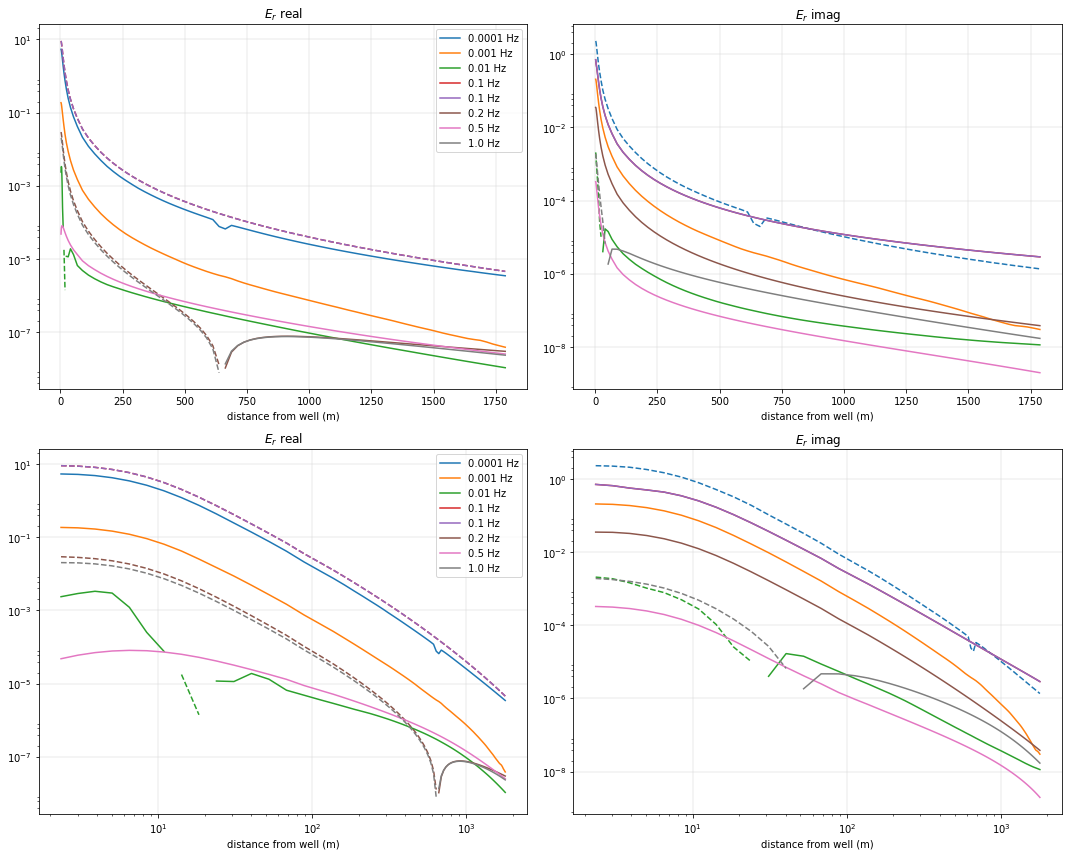

In [111]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax = utils.mkvc(ax)

for i, src in enumerate(srcList):
    ecyl = cylFields[src, 'e']
    eplt = ccv3DthetaSlice(cylmesh, ecyl, theta_ind=theta_ind)

    ex = eplt[:mesh2D.nC][pltind]
    x = mesh2D.gridCC[pltind, 0]
#     ey = eplt[mesh2D.nC:2*mesh2D.nC]
#     ez = eplt[2*mesh2D.nC:]

    xind = ((mesh2D.gridCC[:,0] > 2.) & (mesh2D.gridCC[:,0] < 1800.)) 
    zind = ((mesh2D.gridCC[:,2] > 0.) & (mesh2D.gridCC[:,2] < mesh2D.hz.min()))
    pltind = xind & zind
    
    label='{} Hz'.format(src.freq)
    
    ax[0].semilogy(x, -ex.real, '--', color='C{}'.format(i))
    ax[2].semilogy(x, -ex.imag, '--', color='C{}'.format(i))
    
    ax[1].loglog(x, -ex.real, '--', color='C{}'.format(i))
    ax[3].loglog(x, -ex.imag, '--', color='C{}'.format(i))
    
    ax[0].semilogy(x, ex.real, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
    ax[2].semilogy(x, ex.imag, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
    
    ax[1].loglog(x, ex.real, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
    ax[3].loglog(x, ex.imag, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))

ax[0].legend()
ax[1].legend()

[a.set_title('$E_r$ real') for a in [ax[0], ax[1]]]
[a.set_title('$E_r$ imag') for a in [ax[2], ax[3]]]
# [a.set_xlim([2., 1000.]) for a in ax]
[a.grid('both', linestyle='-', linewidth=0.4, color=[0.8, 0.8, 0.8]) for a in ax]
[a.set_xlabel('distance from well (m)') for a in ax]

plt.tight_layout()